# importing libraries

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


# importing data

In [8]:
batch_size=32
image_size=256

In [13]:
data=tf.keras.utils.image_dataset_from_directory(
    'C:\\Users\\DELL\\Desktop\\project\\data', batch_size=batch_size, image_size=(image_size,image_size),
    shuffle=True, seed=None, validation_split=None, subset=None
)

Found 2152 files belonging to 3 classes.


In [21]:
#gitting classes names
class_names=data.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

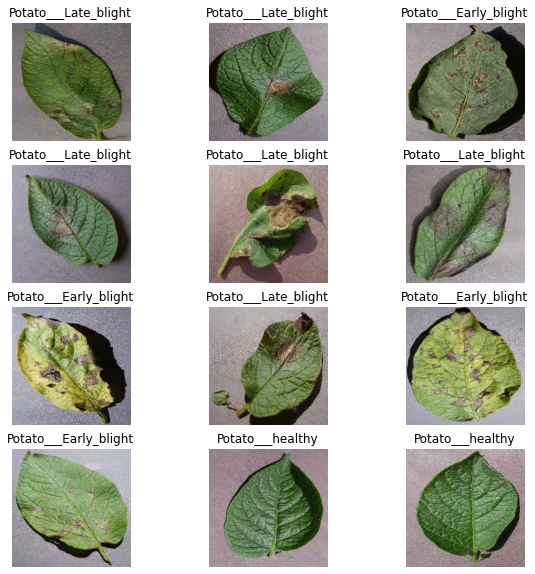

In [23]:

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# splitting data

In [24]:
def data_splitting(data, train_split=.8,val_split=.1,test_split=.1,shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    data_size=len(data)
    if shuffle:
        #we Specify seed to always have the same split distribution between  differents runs
        data = data.shuffle(shuffle_size, seed=10)
    
    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)
    
    train_data = data.take(train_size)  #training data
    val_data = data.skip(train_size).take(val_size)  #validation data
    test_data = data.skip(train_size).skip(val_size)  #testing  data
    
    return train_data, val_data, test_data


In [25]:
train_data, val_data, test_data=data_splitting(data)

In [26]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

54
6
8


In [28]:
#performances optimization
train_data=train_data.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

# scaling data and data augmentation

In [29]:
resize_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(image_size,image_size),
    tf.keras.layers.Rescaling(scale=1./255)
])

In [30]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
])

# model building

In [84]:
num_classes=3
channels=3
input_shape=(batch_size,image_size,image_size,channels)

model = tf.keras.Sequential([
  resize_rescale,
  layers.Conv2D(32, (3,3), activation='relu',input_shape=input_shape),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D((2,2)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')

])

model.build(input_shape=input_shape)

In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

# compile the model

In [86]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# train the model

In [88]:
epochs=5
history = model.fit(
  train_data,
  epochs=epochs,
  batch_size=batch_size,
  verbose=1,
  validation_data=val_data
)

Epoch 1/5
54/54 [==============================] - 153s 3s/step - loss: 0.5945 - accuracy: 0.7641 - val_loss: 0.3864 - val_accuracy: 0.8594
Epoch 2/5
54/54 [==============================] - 162s 3s/step - loss: 0.3278 - accuracy: 0.8750 - val_loss: 0.3111 - val_accuracy: 0.8594
Epoch 3/5
54/54 [==============================] - 140s 3s/step - loss: 0.2048 - accuracy: 0.9255 - val_loss: 0.1552 - val_accuracy: 0.9427
Epoch 4/5
54/54 [==============================] - 139s 3s/step - loss: 0.1165 - accuracy: 0.9613 - val_loss: 0.0885 - val_accuracy: 0.9792
Epoch 5/5
54/54 [==============================] - 140s 3s/step - loss: 0.0864 - accuracy: 0.9701 - val_loss: 0.0821 - val_accuracy: 0.9688


# evaluate the model

In [89]:
scores=model.evaluate(test_data)

8/8 [==============================] - 5s 655ms/step - loss: 0.0653 - accuracy: 0.9805


In [90]:
scores

[0.06525861471891403, 0.98046875]

In [91]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [92]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

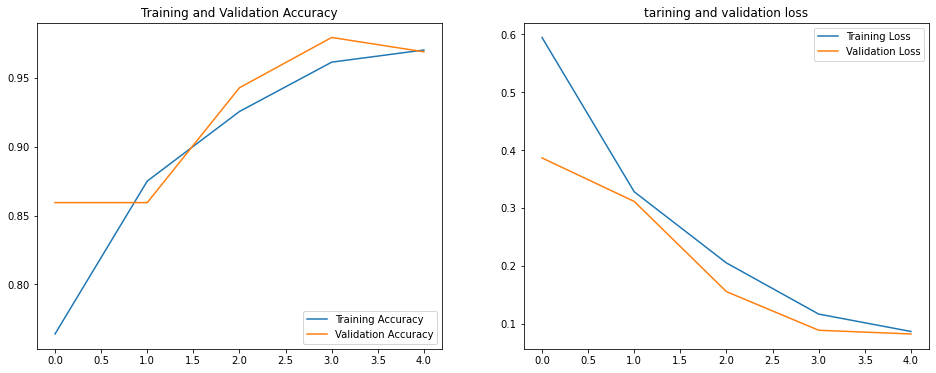

In [93]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('tarining and validation loss')
plt.show()

# prediction

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


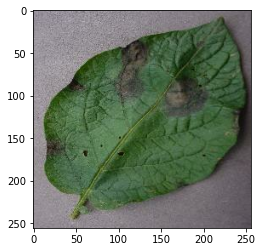

In [94]:
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [95]:
def predict(model,image):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    

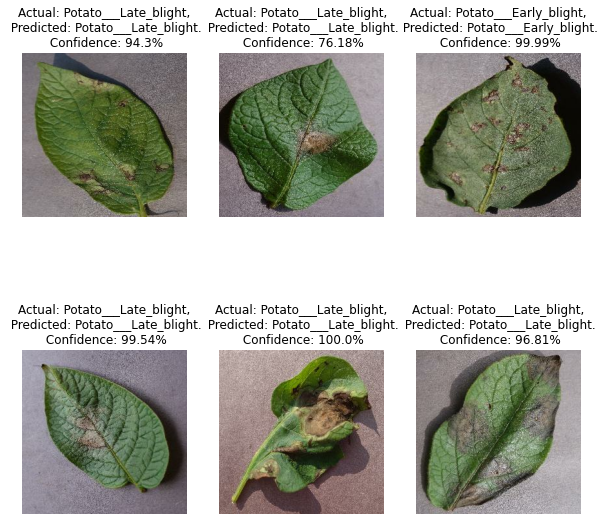

In [96]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in test_data.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# saving the model

In [98]:


import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/1\assets


In [99]:
model.save("../potatoes.h5")

In [101]:


tf.__version__


'2.7.0'